# Feature Extractor on MNIST

In this notebook I'd like to use a pretrained model to extract features from the MNIST dataset. I'll use the pretrained SqueezeNet model from PyTorch's torchvision package.

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


In [177]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


In [178]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_iterations = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


In [179]:
# - Let's start by loading a pretrained model (i.e. squeezenet) and modifying the last layer to classify 10 classes instead of 1000.

# read the train csv file
train_df = pd.read_csv('../datasets/digit-recognizer/train.csv')
test_df = pd.read_csv('../datasets/digit-recognizer/test.csv')

# get the labels
labels = train_df['label'].values

# drop the label column
train_df.drop('label', axis=1, inplace=True)

In [180]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [181]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

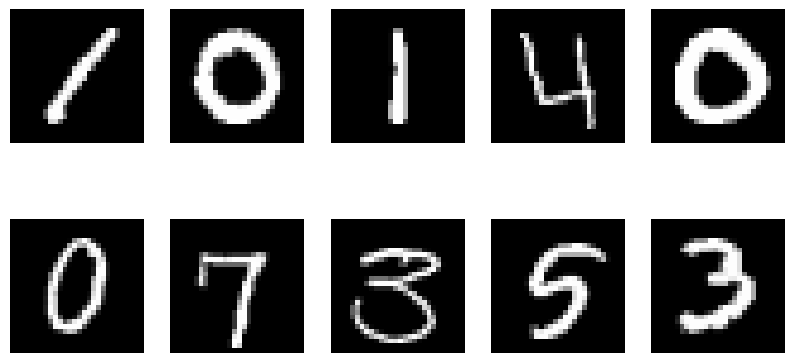

In [182]:
# get the images
images = train_df.values

# reshape the images
images = images.reshape((-1, 28, 28))

# plot some images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(images[i*5 + j], cmap='gray')
        ax[i, j].axis('off')
plt.show()

In [183]:
# create our train and validation splits
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# convert to uint8 numpy arrays for pytorch transforms
X_train = np.asarray(X_train, dtype=np.uint8)
y_train = np.asarray(y_train, dtype=np.uint8)
X_val = np.asarray(X_val, dtype=np.uint8)
y_val = np.asarray(y_val, dtype=np.uint8)

# print shapes of train test split
print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_val.shape: {y_val.shape}')


X_train.shape: (33600, 28, 28)
X_val.shape: (8400, 28, 28)
y_train.shape: (33600,)
y_val.shape: (8400,)


In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [184]:
# Update the train model function below to not use dataloaders
def train_model(model, x, y, criterion, optimizer, num_iterations=num_iterations, is_inception=False):
    since = time.time()

    losses = []

    for phase in ['train', 'val']:
        print(f'====Phase====: {phase}')
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for i in range(num_iterations):
            # generate a batch_size of random indices
            indices = np.random.randint(0, len(x), batch_size)
            x_batch = x[indices]
            y_batch = y[indices]
            inputs = (x_batch)
            labels = (y_batch)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # Get model outputs and calculate loss
                # Special case for inception because in training it has an auxiliary output. In train
                #   mode we calculate the loss by summing the final output and the auxiliary output
                #   but in testing we only consider the final output.
                if is_inception and phase == 'train':
                    # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                    outputs, aux_outputs = model(inputs)
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                else:
                    outputs = model(inputs)
                    # print(f'outputs.shape: {outputs.shape}')
                    loss = criterion(outputs, labels)

                losses.append(loss.item())

                # print(f'outputs.shape: {outputs.shape}')
                _, preds = torch.max(outputs, 1)
                # print(f'preds.shape: {preds.shape}')

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * batch_size
            # print(f'preds: {preds}')
            # print(f'labels: {labels.data}\n\n')
            running_corrects += torch.sum(preds == labels.data)

        # print(f'running_loss: {running_loss}')
        # print(f'running_corrects: {running_corrects}')
        epoch_loss = running_loss / len(x)
        epoch_acc = running_corrects.double() / (batch_size * num_iterations)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Validation Accuracy: {:4f}'.format(epoch_acc))
    
    return model, losses

In [185]:
# TODO: DELETE THIS CELL used for testing the cell above quickly
# model_ft= train_model(model_ft, x, y, criterion, optimizer_ft, num_iterations=100)

In [186]:
# Initialize the model for this run
num_classes = 10    # 10 classes for digits 0-9 of MNIST dataset
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

/Users/sammyjaved/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sammyjaved/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [187]:
# Separated so in future we can do data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [188]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [202]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

## Apply data transforms to the training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x[0].shape: torch.Size([3, 224, 224])
x shape: 5000
x[0].shape: torch.Size([3, 224, 224])


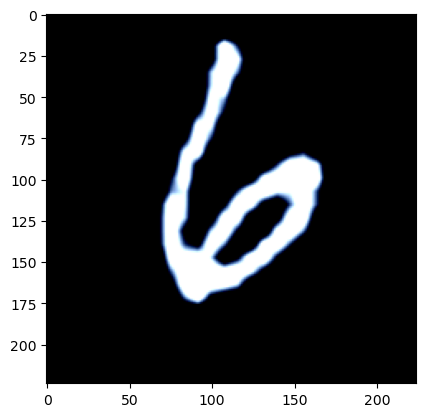

In [189]:


x = X_train[:5000]   # TODO: use only 100 images for training for now
y = y_train[:5000]

y = torch.tensor(y, dtype=torch.long)

# plot a single transformed image
plt.imshow(data_transforms['train'](x[0]).permute(1, 2, 0)) # permute to convert from CxHxW to HxWxC

# Apply the train data transforms on X_train
x = [data_transforms['train'](x_i) for x_i in x]

print(f'x[0].shape: {x[0].shape}')
print(f'x shape: {len(x)}')

# add batch dimension to x
x = torch.stack(x)

# for a single image, we need to add a batch dimension
# x = x.unsqueeze(0)

print(f'x[0].shape: {x[0].shape}')


In [190]:
x.shape

torch.Size([5000, 3, 224, 224])

In [191]:
# Train and evaluate
model_ft, losses = train_model(model_ft, x, y, criterion, optimizer_ft, num_iterations=100, is_inception=(model_name=="inception"))

====Phase====: train
train Loss: 0.8982 Acc: 0.5434
====Phase====: val
val Loss: 0.4097 Acc: 0.8184
Training complete in 1m 19s
Validation Accuracy: 0.818438


Text(0, 0.5, 'Training Loss')

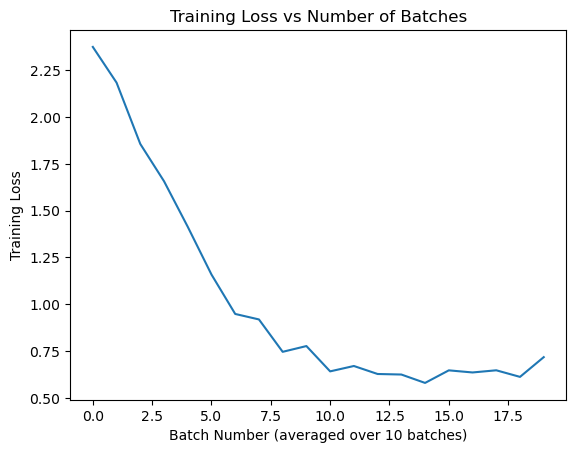

In [201]:
# # Plot the training loss and accuracy
# fig, ax = plt.subplots(2,1)
# ax[0].plot(losses)
# ax[0].set_title("Cross Entropy Loss")
# ax[1].plot(accuracies)
# ax[1].set_title("Classification Accuracy")

# Plot the loss over the mean of the last 10 losses
# fig, ax = plt.subplots(1,1)

# plot the training loss
num_batch_to_avg = 10
plt.plot(torch.tensor(losses).view(-1, num_batch_to_avg).mean(1))
plt.title("Training Loss vs Number of Batches")
plt.xlabel(f'Batch Number (averaged over {num_batch_to_avg} batches)')
plt.ylabel("Training Loss")


### Evaluate model on a few sample images

In [193]:
# Evaluate the model on a sample of the training set
model_ft.eval()
predictions = []
expected = []

with torch.no_grad():
    mini_batch_size = 6
    x_ = x[:mini_batch_size]
    y_ = y[:mini_batch_size]
    output = model_ft(x_)
    _, preds = torch.max(output, 1)
    predictions.append(preds)
    expected.append(y_)
    
print(f'predictions: {predictions}')
print(f'expected: {expected}')


predictions: [tensor([6, 7, 3, 4, 7, 8])]
expected: [tensor([6, 5, 3, 4, 7, 8])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


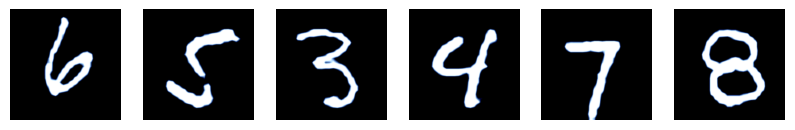

In [194]:
# plot some images
with torch.no_grad():
    fig, ax = plt.subplots(1, 6, figsize=(10, 5))
    for i in range(6):
        img = x.permute(0, 2, 3, 1)[i]
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.show()